### Wall of Imports

In [2]:
import os
import getpass
import requests
import json
from langchain_community.document_loaders import JSONLoader
import pprint
from langchain_text_splitters import RecursiveJsonSplitter
from langchain_qdrant import QdrantVectorStore
from langchain_openai import OpenAIEmbeddings
from qdrant_client import QdrantClient
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import shutil
from ftplib import FTP
import tarfile
from langchain.prompts import ChatPromptTemplate
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
import subprocess
import pandas
from bs4 import BeautifulSoup
import fnmatch

### Enter API Keys

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["QDRANT_API_KEY"] = getpass.getpass("Please enter your Qdrant API key!")

### Load Embeddings

In [4]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

### Connect to Qdrant Vector Store Collections

In [5]:
qdrant_url = "https://e788c0ea-f5df-4d96-85ac-350da677aadf.us-west-2-0.aws.cloud.qdrant.io"

# Opportunities
opportunities_qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embedding_model,
    collection_name="opportunities",
    url=qdrant_url,
    api_key=os.environ["QDRANT_API_KEY"],
)

# Projects
projects_qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embedding_model,
    collection_name="projects",
    url=qdrant_url,
    api_key=os.environ["QDRANT_API_KEY"],
)

### Create Retrievers

In [6]:
opportunities_retriever = opportunities_qdrant.as_retriever(search_kwargs={"k": 5})
projects_retriever = projects_qdrant.as_retriever(search_kwargs={"k": 5})

### Create Prompt Templates

In [7]:
opportunities_rag_prompt_template = """\
Use only the provided context to answer the user's question. If an opportunity id is provided, use only the context for that opportunity. Include the opportunity id, name, and a working url in every response.

If the user asks you to evaluate the study complexity or create a budget, provide a complexity score of high, medium, or low and a reason for all of the following categories:
1) Regulatory and Compliance (rank higher if study requires compliance with multiple regulations and provide examples)
2) Data Collection and Management (identify data elements needed, data complexity, data sensitivity, and data collection frequency)
3) Statistical Analysis and Manuscript Development (provide examples)
4) Information Technology (identify data collection services and equipment needed along with software licenses and subscriptions)
5) Operational (includes project administration and site onboarding, coordination and training)
6) Financial (includes budget management and effort allocation over entire duration of project; rank higher if more resources are required)

If you do not know the answer, or it's not contained in the provided context response with "I don't know"

Context:
{context}

Question:
{question}
"""

opportunities_rag_prompt = ChatPromptTemplate.from_template(opportunities_rag_prompt_template)

In [8]:
projects_rag_prompt_template = """\
Use only the provided context to answer the user's question. If a specific project is named, use only the context for that project. Include the name of the projects in your response, and provide a working url to the project details.

If you do not know the answer, or it's not contained in the provided context response with "I don't know"

Context:
{context}

Question:
{question}
"""

projects_rag_prompt = ChatPromptTemplate.from_template(projects_rag_prompt_template)

### Instantiate RAG LLM

In [9]:
from langchain_openai.chat_models import ChatOpenAI

rag_llm = ChatOpenAI(model="gpt-4o-mini", tags=["rag_llm"])

### Create RAG Chains

In [10]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

opportunities_rag_chain = (
    {"context": itemgetter("question") | opportunities_retriever, "question": itemgetter("question")}
    | opportunities_rag_prompt | rag_llm | StrOutputParser()
)

projects_rag_chain = (
    {"context": itemgetter("question") | projects_retriever, "question": itemgetter("question")}
    | projects_rag_prompt | rag_llm | StrOutputParser()
)

### Test RAG Chains

In [11]:
opportunities_rag_chain.invoke({"question" : "evaluate the study complexity of the PA-25-147 funding opportunity"})

'**Opportunity ID:** PA-25-147  \n**Name:** NIDDK High Risk Multi-Center Clinical Study Cooperative Agreement (U01 Clinical Trial Required)  \n**URL:** [NIDDK High Risk Multi-Center Clinical Study](https://grants.nih.gov/grants/guide/rfa-files/RFA-PA-25-147.html)  \n\n**Complexity Evaluation:**\n\n1) **Regulatory and Compliance:** **High**  \n   The study involves compliance with various NIH regulations and requirements for clinical trials, including adherence to Good Clinical Practice (GCP) and possibly other regulations pertaining to patient safety and data sharing, particularly for multi-center studies.\n\n2) **Data Collection and Management:** **High**  \n   The study will likely collect a variety of data elements given its multi-center nature, including patient demographics, treatment regimens, and clinical outcomes. Data complexity will be high due to the need for standardization across multiple sites. Sensitivity will be elevated, particularly concerning personal health data, re

In [11]:
projects_rag_chain.invoke({"question" : "summarize the University of Utah projects by year"})

'Here is a summary of the University of Utah projects by year:\n\n### 2021\n- **Project Title:** University of Utah Center of Excellence in ELSI research (UCEER)\n  - **Project Number:** 5RM1HG009037-06\n  - **Award Amount:** $991,250\n  - **Abstract:** The project focuses on issues relevant to population-based genetic testing and screening, with an emphasis on newborn screening, prenatal screening, and genetic disabilities, including community support and legal/policy issues.\n  - **Project Detail:** [View Project](https://reporter.nih.gov/project-details/10226042)\n\n### 2022\n- **Project Title:** IMSD at the University of Utah (IMSD@U2)\n  - **Project Number:** 1T32GM139805-01A1\n  - **Award Amount:** $219,809\n  - **Abstract:** Aims to train and launch diverse students into successful PhD careers while improving recruitment and retention of underrepresented students in the biomedical workforce.\n  - **Project Detail:** [View Project](https://reporter.nih.gov/project-details/1036080

### Create RAG Tools

In [12]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_opportunities_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about NIH funding opportunities"""
  return opportunities_rag_chain.invoke({"question" : query})

@tool
def retrieve_projects_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about NIH projects"""
  return projects_rag_chain.invoke({"question" : query})

In [13]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

### Helper Functions

In [14]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

### Initialize Research Team State

In [16]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

### Initialize Supervisor Agent Model

In [17]:
llm = ChatOpenAI(model="gpt-4-turbo")

### Create Agents

In [18]:
opportunities_agent = create_agent(
    llm,
    [retrieve_opportunities_information],
    "You are a research assistant who can provide specific information on NIH funding opportunties. You must only respond with information about the opportunities related to the request. In addition to your main response, include the opportunity id, name and link.",
)
opportunities_node = functools.partial(agent_node, agent=opportunities_agent, name="OpportunitiesInformationRetriever")

In [19]:
projects_agent = create_agent(
    llm,
    [retrieve_projects_information],
    "You are a research assistant who can provide specific information on NIH projects. You must only respond with information about the projects related to the request. In addition to your main response, include the project name and link.",
)
projects_node = functools.partial(agent_node, agent=projects_agent, name="ProjectsInformationRetriever")

In [20]:
supervisor_agent = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  OpportunitiesInformationRetriever, ProjectsInformationRetriever. Given the following user request,"
    " determine the content type to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["OpportunitiesInformationRetriever", "ProjectsInformationRetriever"],
)

/var/folders/mn/0my2dcr50j3g01czsw6gr97w0000gn/T/ipykernel_24239/1110033859.py:62: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


### Configure Graph

In [21]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("OpportunitiesInformationRetriever", opportunities_node)
research_graph.add_node("ProjectsInformationRetriever", projects_node)
research_graph.add_node("supervisor", supervisor_agent)

In [22]:
research_graph.add_edge("OpportunitiesInformationRetriever", "supervisor")
research_graph.add_edge("ProjectsInformationRetriever", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"OpportunitiesInformationRetriever": "OpportunitiesInformationRetriever", "ProjectsInformationRetriever": "ProjectsInformationRetriever", "FINISH": END},
)

In [23]:
research_graph.set_entry_point("supervisor")
chain = research_graph.compile()

### Display Graph Image

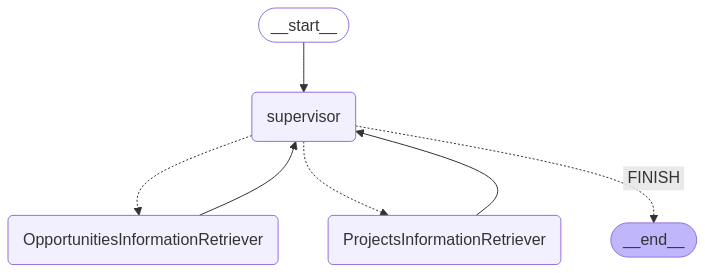

In [23]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### Configure Team Members
team_members doesn't get implicitly passed to the chat prompt template, so this was my workaround.

In [24]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(research_graph.nodes),
    }
    return results

research_chain = enter_chain | chain

### Test Chain

In [173]:
for s in research_chain.stream(
    "Evaluate the study complexity for the PA-25-147 opportunity", {"recursion_limit": 10}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'OpportunitiesInformationRetriever'}}
---
{'OpportunitiesInformationRetriever': {'messages': [HumanMessage(content='The NIH funding opportunity PA-25-147, titled "NIDDK High Risk Multi-Center Clinical Study Cooperative Agreement (U01 Clinical Trial Required) Part 2," presents a high level of complexity across several aspects. Here\'s a breakdown:\n\n1. **Regulatory and Compliance:** High complexity due to multi-center clinical trial requirements, including adherence to FDA regulations and GCP guidelines.\n2. **Data Collection and Management:** High complexity, necessitating robust data management systems to handle diverse and sensitive data across multiple sites.\n3. **Statistical Analysis and Manuscript Development:** High complexity, involving sophisticated statistical analyses to evaluate interventions across diverse populations and sites.\n4. **Information Technology:** Medium complexity, with essential IT services for data management and security.\n5. **Ope

### Budget Analysis State

In [25]:

class BudgetTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

### Create Budget Team Tools

In [26]:
from langchain.tools import tool
from typing import Annotated

@tool
def do_nothing(
    input_text: Annotated[str, "Any input text."]
) -> Annotated[str, "A placeholder response indicating the tool does nothing."]:
    """
    A LangChain tool that does nothing and returns a generic response.
    Useful as a placeholder for debugging or tool testing.
    """
    return "This tool does nothing. You provided: " + input_text


In [27]:
personnel_budget_agent = create_agent(
    llm,
    [do_nothing],
    ("You are an expert at drafting NIH  budgets. You use the provided study complexity "
     "to calculate the effort allocation percentage by study year for all of the following roles: "
     "DCC Principal Investigator, DCC Co-Principal Investigator, Clinical Data Managers, Stats, Clinical "
     "Project Manager, Business Project Manager, Software Engineering, IT Project Manager, IT Operations, "
     "Ops Leader, Administrative Program Assistant, Regulatory and Quality Assurance Manager, Finance, "
     "Medical Monitor, Business Intelligence, Stats Manager, Clinical Data Management Manager, and IT Manager "
     "If a role is not required, it will be left out of the budget. "
     "Effort allocations should be listed in a table format with the roles listed in rows and the study "
     "years listed in columns. It should additionally follow the detailed NIH budget guidelines."),
)
personnel_budget_node = functools.partial(
    agent_node, agent=personnel_budget_agent, name="PersonnelBudget"
)

budget_analysis_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the "
    "following workers: PersonnelBudget. "
    "You should always verify the technical "
    "contents after any edits are made. "
    "Given the user request, "
    "respond with the worker to act next. "
    "task and respond with their results and status. "
    "Allow each worker to complete only one draft before completing their assignment. "
    "When your team's work is complete, "
    "you must respond with FINISH."),
    ["PersonnelBudget"],
)

In [28]:
budget_analysis_graph = StateGraph(BudgetTeamState)
budget_analysis_graph.add_node("PersonnelBudget", personnel_budget_node)
budget_analysis_graph.add_node("supervisor", budget_analysis_supervisor)

budget_analysis_graph.add_edge("PersonnelBudget", "supervisor")

budget_analysis_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PersonnelBudget": "PersonnelBudget",
        "FINISH": END,
    },
)

budget_analysis_graph.set_entry_point("supervisor")
chain = budget_analysis_graph.compile()

In [29]:
def enter_budget_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

budget_analysis_chain = (
    functools.partial(enter_budget_chain, members=budget_analysis_graph.nodes)
    | budget_analysis_graph.compile()
)

In [141]:
for s in budget_analysis_chain.stream(
    "Create a budget",
    {"recursion_limit": 10},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'PersonnelBudget'}}
---
{'PersonnelBudget': {'messages': [HumanMessage(content='To craft a precise NIH budget, I require specific details regarding your study, such as its complexity, duration, phases, number and types of participants, study sites, and any special requirements or equipment needed. This information will allow me to accurately allocate effort percentages for each role involved in the project.\n\nCould you please provide more context or specific details about the study for which you need the budget? This will enable me to assist you effectively.', additional_kwargs={}, response_metadata={}, name='PersonnelBudget')]}}
---
{'supervisor': {'next': 'PersonnelBudget'}}
---
{'PersonnelBudget': {'messages': [HumanMessage(content='To assist effectively in creating an NIH budget, specific details regarding the study are required, such as its complexity, duration, phases, number and types of participants, study sites, and any special requirements or equipmen

KeyboardInterrupt: 

### Document Writing State

In [30]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

### Create Document Tools

In [31]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('data/Documents', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('data/Documents', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [32]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

In [33]:
budget_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing documents. You may only use the information provided by the research and budget analysis "
     "teams to generate your document. You do not need to collect any more information at this point to produce your document. "
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_budget_writer_agent = prelude | budget_writer_agent
budget_writing_node = functools.partial(
    agent_node, agent=context_aware_budget_writer_agent, name="BudgetWrite"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["BudgetWriter"],
)

### Graph Configuration

In [34]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("BudgetWriter", budget_writing_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("BudgetWriter", "supervisor")

authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "BudgetWriter": "BudgetWriter",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
chain = authoring_graph.compile()

### Display Graph

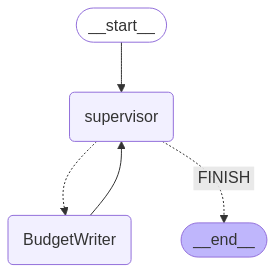

In [149]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [35]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

### Test Chain

In [113]:
for s in authoring_chain.stream(
    "Create a budget document for funding opportunity PA-25-147.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'BudgetWriter'}}
---
{'BudgetWriter': {'messages': [HumanMessage(content='The budget document for funding opportunity PA-25-147 has been successfully created and saved. If you need any further details or revisions to the document, please let me know!', additional_kwargs={}, response_metadata={}, name='BudgetWrite')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


### One Agent to Rule Them All

In [36]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI


llm = ChatOpenAI(model="gpt-4-turbo")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    "When all workers are finished,"
    " you must respond with FINISH.",
    ["Research team", "Budget Analysis team", "Documents team"],
)

In [37]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

In [38]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node("Budget Analysis team", get_last_message | budget_analysis_chain | join_graph)
super_graph.add_node(
    "Documents team", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

In [39]:
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("Budget Analysis team", "supervisor")
super_graph.add_edge("Documents team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "Documents team": "Documents team",
        "Budget Analysis team": "Budget Analysis team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
super_graph = super_graph.compile()

In [41]:
WORKING_DIRECTORY = Path(create_random_subdirectory())

#content = "Generate a budget for opportunity PA-25-147. Use the research team to collect information about opportunity PA-25-147. Use the budget analysis team to generate a budget from the study complexity provided by the research team. And then use the documents team to write the budget team's output to a new file."

for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Provide a list of the ten most recent University of Utah NIH-funded projects"
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content='The following projects were not among the 10 most recent NIH-funded projects at the University of Utah but are significant ongoing initiatives:\n\n1. **NICHD Cooperative Multicenter Neonatal Research Network - Utah Center (2023)**\n   - **Principal Investigator:** Robin K Ohls\n   - **Award:** $344,885\n   - Detailed information can be found [here](https://reporter.nih.gov/project-details/10682083).\n\n2. **NICHD Cooperative Multicenter Neonatal Research Network - Utah Center (2021)**\n   - **Principal Investigator:** Robin K Ohls\n   - **Award:** $281,382\n   - Detailed information can be found [here](https://reporter.nih.gov/project-details/10348097).\n\n3. **NICHD Cooperative Multicenter Neonatal Research Network - Utah Center (2020)**\n   - **Principal Investigator:** Robin K Ohls\n   - **Award:** $281,382\n   - Detailed information can be found [here](https://reporter.nih.gov/projec